In [1]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd

from scipy import stats as spstats

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

In [2]:
from pipeline.python import utils as putils
from pipeline.python.classifications import aggregate_data_stats as aggr

from pipeline.python.classifications import decode_by_ncells as dc

In [3]:

# Set colors
visual_area, area_colors = putils.set_threecolor_palette(soft=True)
dpi = putils.set_plot_params()

In [4]:
%matplotlib notebook

# Test a dataset

# Set responsivity params

In [21]:
responsive_test = 'ROC' #'nstds'
responsive_thr = 0.05 #10.
response_type='dff'
n_stds = 2.5
experiment = 'blobs'
traceid='traces001'

rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
visual_areas = ['V1', 'Lm', 'Li']

# Get aggregate data

In [12]:
sdata = aggr.get_aggregate_info(traceid=traceid, visual_areas=visual_areas)
dsets = sdata[sdata.experiment==experiment]

Segmentation: missing 9 dsets


In [16]:
stats_desc = util.get_stats_desc(traceid=traceid,
                                      trace_type='corrected',
                                      response_type = response_type,
                                      responsive_test = responsive_test,
                                      responsive_thr = responsive_thr,
                                      n_stds = n_stds)
print(stats_desc)

stats-traces001-corrected-dff-ROC-thr-0.05


In [22]:

aggregate_stats_dir = os.path.join(aggregate_dir, 'responsivity', stats_desc)
if not os.path.exists(aggregate_stats_dir):
    os.makedirs(aggregate_stats_dir)
print(aggregate_stats_dir)

emptystats = {}

/n/coxfs01/julianarhee/aggregate-visual-areas/responsivity/stats-traces001-corrected-dff-ROC-thr-0.05


In [25]:
# from pipeline.python.classifications import responsivity_stats as respstats
# create_new=False
# plot_rois=False

# for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
#     skey = '%s_%s' % (visual_area, '-'.join([animalid, session, fov]))
#     nostats = respstats.visualize_session_stats(animalid, session, fov, 
#                                              create_new=create_new, altdir=aggregate_stats_dir, 
#                                              traceid=traceid, trace_type='corrected',
#                                              plot_rois=plot_rois,
#                                              response_type=response_type, 
#                                              responsive_test=responsive_test,
#                                              responsive_thr=responsive_thr,
#                                              n_stds = n_stds)

#     dset_key = '_'.join([animalid, session, fov])
#     emptystats[dset_key] = nostats

# for k, checklist in emptystats.items():
#     if len(checklist) == 0:
#         emptystats.pop(k)

# error_fpath = os.path.join(aggregate_stats_dir, 'check_stats.json')
# with open(error_fpath, 'w') as f:
#     json.dump(emptystats, f, indent=4, sort_keys=True)


# Create output dir for analysis


In [27]:
outdir = os.path.join(aggregate_dir, '%s-tuning' % experiment, stats_desc, 'linear-regression')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-ROC-thr-0.05/linear-regression


In [29]:
# Set plotting params
threshold_dff = False #True
min_dff = 0 #0.03

n_sz = 5
n_mp = 10



# Load aggregate data

In [33]:
sdf = aggr.get_master_sdf()

In [63]:
#responsive_test='ROC'
#responsive_thr=10. if responsive_test=='nstds' else 0.05
print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")
experiment='blobs'
trial_epoch='stimulus'
curr_visual_area=None #'V1'
curr_datakey = None# '20190617_JC097_fov1'

#### Load neural responses
stack_neuraldf = False

#### Check for equal trial counts
visual_areas=['V1', 'Lm', 'Li'] #, 'Ll']
_, all_cells, MEANS, SDF = aggr.get_source_data(experiment,
                        equalize_now=False, zscore_now=False,
                        response_type=response_type, responsive_test=responsive_test,
                        responsive_thr=responsive_thr, trial_epoch=trial_epoch, #use_all=False,
                        visual_area=curr_visual_area,
                        datakey=curr_datakey,
                        check_configs=True, return_configs=True, return_missing=False,
                        images_only=False)

all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
all_cells.groupby(['visual_area']).count()

............................................
Responsive test: ROC (thr=0.05)
............................................
Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
(skipping 20190314_JC070_fov1)
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])


,cell,fov,animalid,session,datakey,fovnum,global_ix
visual_area,,,,,,,
Li,585,585,585,585,585,585,585
Lm,1127,1127,1127,1127,1127,1127,1127
V1,1251,1251,1251,1251,1251,1251,1251


In [64]:
remove_too_few=False
min_ncells=5
has_retino=False
threshold_snr=False
threshold_dff=False
match_distns = False

NDATA, CELLS = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, 
                            stack_neuraldf=True, overlap_thr=None, 
                            has_retino=has_retino, threshold_snr=threshold_snr, 
                            remove_too_few=remove_too_few, min_ncells=min_ncells)                               
print("------------------------------------")
print("Final cell counts:")
CELLS[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

cell_counts = dict(CELLS.groupby(['visual_area'])['cell'].count())
print("@@@@@@@@ cell counts @@@@@@@@@@@")
print(cell_counts)

~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~
Assigned visual areas: [u'Li' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1127, u'Li': 585}
------------------------------------
------------------------------------
Final cell counts:
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1127, u'Li': 585}


In [65]:
data_id = '_'.join([traceid, response_type, trial_epoch, responsive_test, str(responsive_thr)])
print(data_id)

traces001_dff_stimulus_ROC_0.05


# Unique datasets

In [66]:
filter_by='most_fits'
blob_dsets = aggr.get_blob_datasets(filter_by=filter_by, as_dict=False, response_type=response_type,
                                    responsive_test=responsive_test, responsive_thr=responsive_thr)
all_dkeys = sdata[(sdata['experiment']==experiment)]['datakey'].unique()
unique_dkeys = blob_dsets['datakey'].unique()

n_drop = len(all_dkeys) - len(unique_dkeys)
print("Dropping %i dkeys (%i of %i dkeys unique)" % (n_drop, len(unique_dkeys), len(all_dkeys)))

Segmentation: missing 9 dsets
Segmentation: missing 3 dsets
[AL] Animalid does not exist: JC099 
[Ll] Animalid does not exist: JC067 
[Ll] Animalid does not exist: JC099 
[POR] Animalid does not exist: JC076 
[V1] Animalid does not exist: JC078 
Dropping 12 dkeys (30 of 42 dkeys unique)


In [67]:
curr_dst_dir = os.path.join(outdir, 'drop_repeats')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-ROC-thr-0.05/linear-regression/drop_repeats


# Regression

In [37]:
import numpy as np
import seaborn as sns
from scipy import stats as spstats
from pipeline.python.utils import label_figure, natural_keys

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics as skmetrics
from sklearn import linear_model, preprocessing

from sklearn import preprocessing

In [43]:
def fit_lasso_regr(xtrain, ytrain, xtest, ytest):
    regr = linear_model.Lasso()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    return ypred, regr

def fit_ridge_regr(xtrain, ytrain, xtest, ytest):
    regr = linear_model.Ridge()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    return ypred, regr

def fit_linear_regr(xtrain, ytrain, xtest, ytest):
    regr = linear_model.LinearRegression()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    return ypred, regr

class Struct():
    pass

# (preprocessing.StandardScaler().fit_transform(ddata[rois_]))

def get_regr_stats(X, ylabels, test_size=0.1, return_data=False, model='ols', return_dict=False, randi=10):
    
    x_train, x_test, y_train, y_test = train_test_split(X, ylabels, test_size=test_size, random_state=randi)
    
    if model=='ols':
        y_pred, regr = fit_linear_regr(x_train, y_train, x_test, y_test)
    elif model=='ridge':
        #print("ridge")
        y_pred, regr = fit_ridge_regr(x_train, y_train, x_test, y_test)
    elif model=='lasso':
        #print("lasso")
        y_pred, regr = fit_lasso_regr(x_train, y_train, x_test, y_test)
    
    results = Struct()
    results.pearsons_r, results.pearsons_p = spstats.pearsonr(y_test, y_pred)
    results.exp_var = skmetrics.explained_variance_score(y_test, y_pred)
    results.mse = skmetrics.mean_squared_error(y_test, y_pred)
    results.r2 = skmetrics.r2_score(y_test, y_pred, multioutput='uniform_average')
    results.regr = regr
    results.prediction = y_pred
    results.true = y_test
    results.coef_ = regr.coef_
    
    if return_dict:
        results = dict((i, getattr(results, i)) for i in dir(results) if not i.startswith('_'))

    if return_data:
        data = {'x_train': x_train,
                'x_test': x_test,
                'y_train': y_train,
                'y_test': y_test}
        
        return results, data
    return results


# Select test dataset

In [51]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' #'JC059'
session = '20190522' #'20190227'
fovnum = 1
fov = 'FOV%i_zoom2p0x' % fovnum#'FOV4_zoom4p0x'
visual_area='V1'

In [32]:
reload(util)

<module 'pipeline.python.classifications.experiment_classes' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.pyc'>

In [42]:
data_id = '|'.join([animalid, session, fov, traceid, stats_desc])
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

# Get stimulus conditions
sdf = SDF[datakey].copy()
sizes = np.array(sorted(sdf['size'].unique()))
morphs = np.array(sorted(sdf['morphlevel'].unique()))


### Test regression stuff on 1 dset

In [68]:
regr_var1 = 'size'
regr_var2 = 'morphlevel'
exclude_controls = True

In [69]:
sdf.head()

,color,morphlevel,object,size,stimtype,xpos,ypos,yrot
config006,,0,Blob_N1,10.0,image,20,-8,0
config007,,0,Blob_N1,20.0,image,20,-8,0
config008,,0,Blob_N1,30.0,image,20,-8,0
config009,,0,Blob_N1,40.0,image,20,-8,0
config010,,0,Blob_N1,50.0,image,20,-8,0


In [70]:
# all_configs = [c for c in sdf.index.tolist() if c not in excluded_configs]


In [98]:
split_transform = False
#curr_transform = 'size'
#curr_transform_value = 50

if split_transform:
    tested_configs = sdf[(sdf[curr_transform]==curr_transform_value) & (sdf.morphlevel!=-1)].index.tolist()
else:
    tested_configs = sdf[sdf['morphlevel']!=-1].index.tolist()
len(tested_configs)

ndf = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()
x0 = aggr.stacked_neuraldf_to_unstacked(ndf)

x1 = x0[x0['config'].isin(tested_configs)]
zdata = aggr.zscore_neuraldf(x1)

##### Select data subset
rois_ = [r for r in zdata.columns if putils.isnumber(r)]
currdf = zdata[rois_].copy()
config_on_trials = zdata['config'].values
X = pd.DataFrame(currdf)
X.shape

#### Fit regressor

In [105]:
def do_ridge_cv(X, ylabels, test_size=0.1, return_data=False, model='ridge', 
                   return_dict=False, randi=10, alphas=[0.1, 1.0, 10.], cv=5):
    
    x_train, x_test, y_train, y_test = train_test_split(X, ylabels, test_size=test_size, random_state=randi)
    
    # scale
    scaler = preprocessing.StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    # fit ridge
    regr = linear_model.RidgeCV(alphas=alphas, cv=cv)
    regr.fit(x_train, y_train)
    # test model
    x_test = scaler.transform(x_test)
    y_pred = regr.predict(x_test)
    
    results = Struct()
    results.pearsons_r, results.pearsons_p = spstats.pearsonr(y_test, y_pred)
    results.exp_var = skmetrics.explained_variance_score(y_test, y_pred)
    results.mse = skmetrics.mean_squared_error(y_test, y_pred)
    results.r2 = skmetrics.r2_score(y_test, y_pred, multioutput='uniform_average')
    results.regr = regr
    results.prediction = y_pred
    results.true = y_test
    results.coef_ = regr.coef_
    
    if return_dict:
        results = dict((i, getattr(results, i)) for i in dir(results) if not i.startswith('_'))

    if return_data:
        data = {'x_train': x_train,
                'x_test': x_test,
                'y_train': y_train,
                'y_test': y_test}
        
        return results, data
    return results


<IPython.core.display.Javascript object>


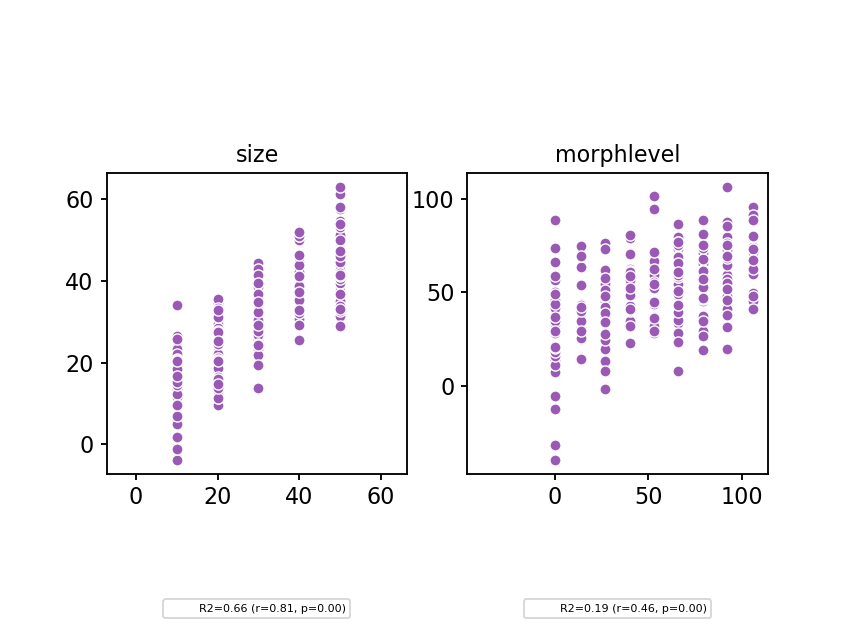

In [107]:
test_size=0.2
randi = 10

fig, axn =pl.subplots(1, 2)

targets1 = [sdf[regr_var1][cfg] for cfg in config_on_trials]
targets2 = [sdf[regr_var2][cfg] for cfg in config_on_trials]

for ai, (regr_label, y_labels) in enumerate(zip([regr_var1, regr_var2], [targets1, targets2])):
    ax=axn[ai]
    res = do_ridge_cv(X, y_labels, test_size=test_size, return_dict=False, randi=10)
    
    sns.scatterplot(res.true, res.prediction, ax=ax)
    ax.set_title(regr_label)
    ax.set_aspect('equal')
    maxv = max([ax.get_xlim()[-1], ax.get_ylim()[-1]])
    minv = min([ax.get_xlim()[0], ax.get_ylim()[0]])
    ax.set_xlim([minv, maxv])
    ax.set_ylim([minv, maxv])
    pval_str = 'R2=%.2f (r=%.2f, p=%.2f)' % (res.r2, res.pearsons_r, res.pearsons_p)
    ax.plot(0, 0, alpha=0, label=pval_str)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5), fontsize=6)



<IPython.core.display.Javascript object>


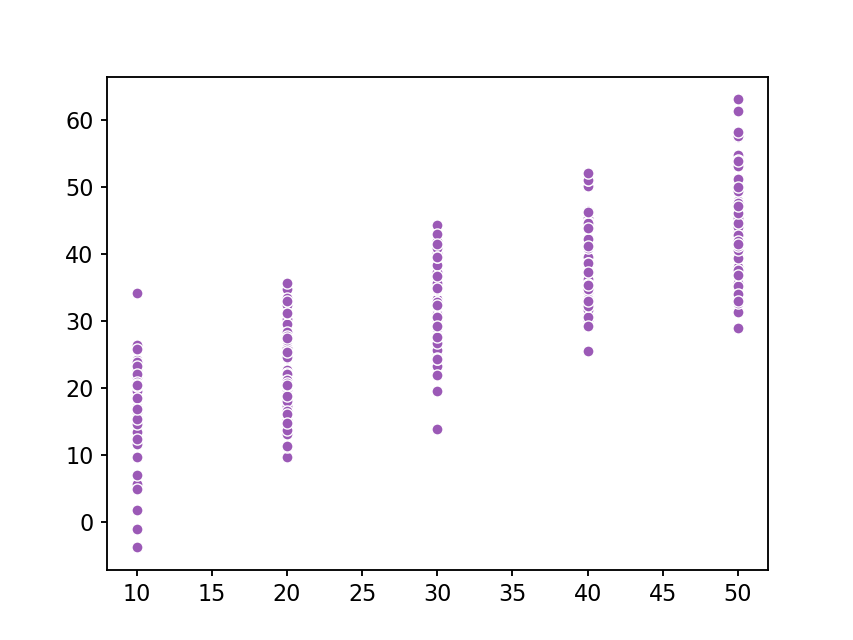

In [92]:
fig, ax =pl.subplots()
sns.scatterplot(y_test, y_pred)

<IPython.core.display.Javascript object>


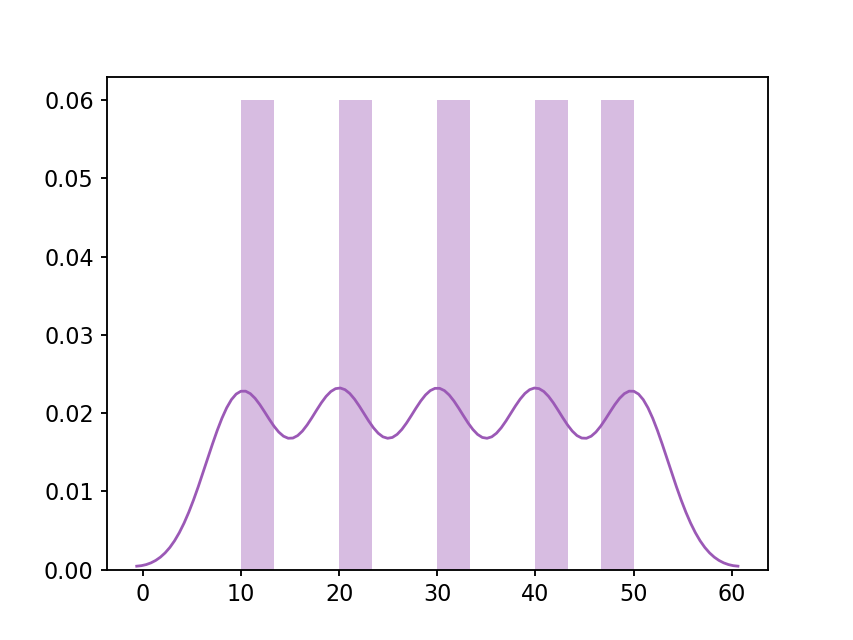

In [84]:
targets1 = [sdf[regr_var1][cfg] for cfg in config_on_trials]
pl.figure()
sns.distplot(targets1)

In [66]:
model='ridge' #'ols'

#morphnum = list(sorted(sdf['morphlevel'].unique())) #np.arange(1, len(sdf['morphlevel'].unique())+1))
#morph_ixs = [morphnum.index(m) for m in sdf['morphlevel']] #np.arange(1, len(sdf['morphlevel'].unique())+1)
#sdf['morphlevel'] = morph_ixs

targets1 = [sdf[regr_var1][cfg] for cfg in trial_configs]
res1, data1 = get_regr_stats(X, targets1, return_data=True, model=model)

targets2 = [sdf[regr_var2][cfg] for cfg in trial_configs]
res2, data2 = get_regr_stats(X, targets2, return_data=True, model=model)


ridge
ridge


<IPython.core.display.Javascript object>


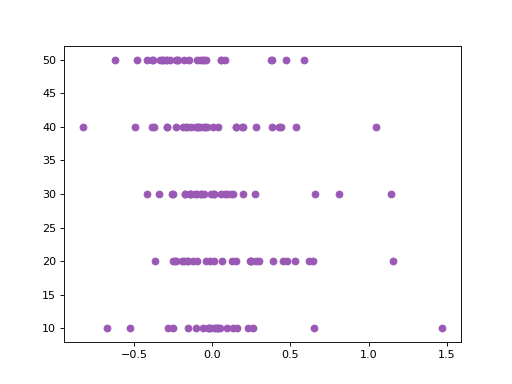

In [67]:
pl.figure()
pl.scatter(data1['x_test'].mean(axis=1), data1['y_test'])

In [81]:
abs1, abs2

(3.5653238582981608, 9.3030427203292057)

In [95]:
import matplotlib.gridspec as gridspec


<IPython.core.display.Javascript object>


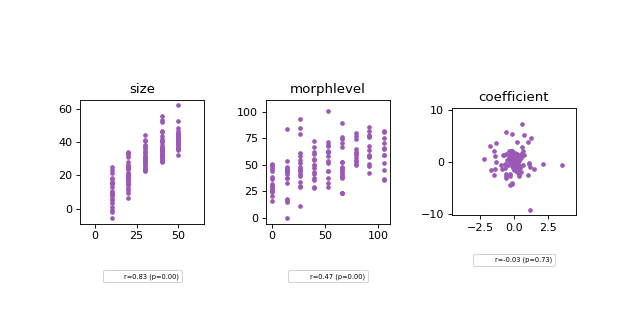

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-ROC-thr-0.05/linear-regression
ridge-regr_20190522-JC084_dff_ROC-thr-0.05_


In [104]:
markersize=10

fig = pl.figure(figsize=(8,4))
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,1], height_ratios=[1])
ax = pl.subplot(gs[0])

#ax = axes[0]
ax.set_title(regr_var1)
ax.scatter(res1.true, res1.prediction, s=markersize)
maxv = max([ax.get_xlim()[-1], ax.get_ylim()[-1]])
minv = min([ax.get_xlim()[0], ax.get_ylim()[0]])
ax.set_xlim([minv, maxv])
ax.set_ylim([minv, maxv])
pval_str = 'r=%.2f (p=%.2f)' % (res1.pearsons_r, res1.pearsons_p)
ax.plot(0, 0, alpha=0, label=pval_str)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5), fontsize=6)
ax.set_aspect('equal')

#ax = axes[1]
ax = pl.subplot(gs[1])
ax.set_title(regr_var2)
ax.scatter(res2.true, res2.prediction, s=markersize)
maxv = max([ax.get_xlim()[-1], ax.get_ylim()[-1]])
minv = min([ax.get_xlim()[0], ax.get_ylim()[0]])
ax.set_xlim([minv, maxv])
ax.set_ylim([minv, maxv])
pval_str = 'r=%.2f (p=%.2f)' % (res2.pearsons_r, res2.pearsons_p)
ax.plot(0, 0, alpha=0, label=pval_str)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5), fontsize=6)

ax.set_aspect('equal')


#ax = axes[2]
ax = pl.subplot(gs[2])
ax.set_title('coefficient')
ax.scatter(res1.regr.coef_, res2.regr.coef_, s=markersize)
# maxv = max([max(res1.regr.coef_), max(res2.regr.coef_)])
# minv = min([min(res1.regr.coef_), min(res2.regr.coef_)])
# absmax = max([abs(maxv), abs(minv)])
coefs_pearsons_r, coefs_pearsons_p = spstats.pearsonr(res1.regr.coef_, res2.regr.coef_)

abs1 = max([abs(res1.regr.coef_.min()), abs(res1.regr.coef_.max())])
abs2 = max([abs(res2.regr.coef_.min()), abs(res2.regr.coef_.max())])
ax.set_xlim([-abs1-1, abs1+1])
ax.set_ylim([-abs2-1, abs2+1])

pval_str = 'r=%.2f (p=%.2f)' % (coefs_pearsons_r, coefs_pearsons_p)
ax.plot(0, 0, alpha=0, label=pval_str)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5), fontsize=6)
ax.set_aspect(abs1/abs2)
#ax.set_xlim([minv, maxv])



pl.subplots_adjust(wspace=0.5)
figname = '%s-regr_%s-%s_%s_%s-thr-%.2f_' % (model, session, animalid, response_type, responsive_test, responsive_thr)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
pl.savefig(os.path.join(aggregate_dir, 'decoding', '%s.svg' % figname))
print(outdir)
print(figname)

In [88]:
pl.savefig(os.path.join(aggregate_dir, 'decoding', '%s.svg' % figname))


In [125]:
res1.r2, res2.r2

(0.7144502923973659, 0.25495800517053446)

#### Split by transform

In [53]:
split_transform = True
curr_transform = 'morphlevel'
predict_feature = 'morphlevel' if curr_transform=='size' else 'size'


In [154]:

all_transform_values = sorted(sdf[curr_transform].unique())
#curr_transform_value = 50
print "Testing %s:" % curr_transform, all_transform_values

curr_results = dict()
for curr_transform_value in all_transform_values:
    tested_configs = sdf[sdf[curr_transform]==curr_transform_value].index.tolist()

    labels = exp.data.labels[exp.data.labels['config'].isin(tested_configs)]
    trial_configs = np.vstack(labels.groupby(['trial'])['config'].apply(np.array).apply(np.ravel))[:, 0]
    all_trials = sorted(exp.data.labels['trial'].unique(), key=natural_keys)
    included_trials = sorted(labels['trial'].unique(), key=natural_keys)
    trial_ixs = [i for i, trial in enumerate(all_trials) if trial in included_trials]
    print "N trials: %i" % len(trial_ixs)
    print "N configs: %i" % len(tested_configs)

    ##### Select data subset
    currdf = df.copy()
    currdf = currdf.iloc[trial_ixs]
    X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(currdf))

    #### Fit regressor
    targets1 = [sdf[predict_feature][cfg] for cfg in trial_configs]
    res1 = get_regr_stats(X, targets1)
    
    curr_results[curr_transform_value] = res1
    

Testing morphlevel: [0, 14, 27, 40, 53, 66, 79, 92, 106]
N trials: 150
N configs: 5
N trials: 150
N configs: 5
N trials: 150
N configs: 5
N trials: 150
N configs: 5
N trials: 150
N configs: 5
N trials: 150
N configs: 5
N trials: 150
N configs: 5
N trials: 150
N configs: 5
N trials: 150
N configs: 5


<IPython.core.display.Javascript object>


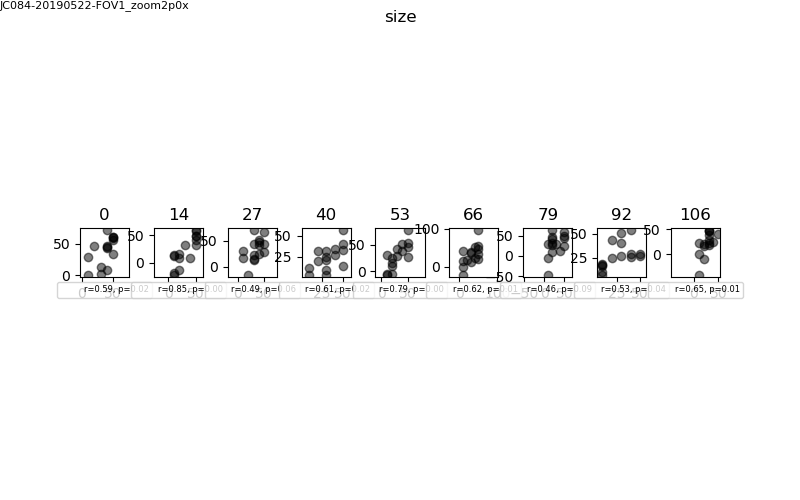

In [155]:
fig, axes = pl.subplots(1, len(all_transform_values), figsize=(8, 5))

for ax, trans_val in zip(axes.flat, sorted(all_transform_values)):
    res1 = curr_results[trans_val]
    ax.scatter(res1.true, res1.prediction, marker='o', c='k', alpha=0.5)
    maxv = max([ax.get_xlim()[-1], ax.get_ylim()[-1]])
    minv = min([ax.get_xlim()[0], ax.get_ylim()[0]])
    ax.set_xlim([minv, maxv])
    ax.set_ylim([minv, maxv])
    ax.set_aspect('equal')
    ax.set_title(trans_val)
    pval_str = 'r=%.2f, p=%.2f' % (res1.pearsons_r, res1.pearsons_p)
    ax.plot(0, 0, alpha=0, label=pval_str)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5), fontsize=6)
              #ncol=3, fancybox=True, shadow=True)

pl.suptitle(predict_feature)
pl.subplots_adjust(left=0.1, wspace=0.5)
label_figure(fig, skey)


In [151]:
np.mean([0.12, 0.53, 0.42, 0.62, 0.32])

0.40199999999999997

# Get regression for all datasets included

In [21]:
regr_var1 = 'size'
regr_var2 = 'morphlevel'
exclude_controls = True
model = 'ridge'

visual_areas = ['V1', 'Lm', 'Li']

In [22]:
reformat_morphs = True
reformat_str = '_rename-morphs' if reformat_morphs else ''

do_fits = False
regression_fpath = os.path.join(outdir, 'regression_stats_%s%s.pkl' % (model, reformat_str))

if os.path.exists(regression_fpath):
    with open(regression_fpath, 'rb') as f:
        results = pkl.load(f)
else:
    do_fits = True
    
by_sess_regression_fpath = os.path.join(outdir, 'regression_stats_%s_by-session%s.pkl' % (model, reformat_str))
if os.path.exists(by_sess_regression_fpath):
    with open(by_sess_regression_fpath, 'rb') as f:
        RES = pkl.load(f)
        
else:
    do_fits = True
print(do_fits)

False


In [23]:
np.arange(1, len(sdf['morphlevel'].unique())+1)


NameError: name 'sdf' is not defined

# Fit

In [108]:
morphlevels = [m for m in sdf['morphlevel'].unique() if m!=-1]
morphlevels

#curr_morph_levels = [0, 27, 53, 79, 106]
curr_morph_levels = morphlevels
curr_morph_levels

[0, 14, 27, 40, 53, 66, 79, 92, 106]

In [109]:
metrics = ['r2', 'exp_var', 'mse', 'pearsons_r', 'pearsons_p']

t_=[]
for (visual_area, datakey), ndf in NDATA.groupby(['visual_area', 'datakey']):
    print(visual_area)
    
    sdf = SDF[datakey].copy()
    tested_configs = sdf[sdf['morphlevel'].isin(curr_morph_levels)].index.tolist()
    
    # unstack and zscore
    x0 = aggr.stacked_neuraldf_to_unstacked(ndf)
    x1 = x0[x0['config'].isin(tested_configs)]
    zdata = aggr.zscore_neuraldf(x1)
    
    rois_ = [r for r in zdata.columns if putils.isnumber(r)]
    currdf = zdata[rois_].copy()
    config_on_trials = zdata['config'].values
    X = pd.DataFrame(currdf)

    targets1 = [sdf[regr_var1][cfg] for cfg in config_on_trials]
    res1 = do_ridge_cv(X, targets1, test_size=test_size, return_dict=True, randi=10)

    targets2 = [sdf[regr_var2][cfg] for cfg in config_on_trials]
    res2 = do_ridge_cv(X, targets2, test_size=test_size, return_dict=True, randi=10)

    weight_coefs_r, weight_coefs_p = spstats.pearsonr(res1['coef_'], res2['coef_'])
    
    rdf1 = pd.Series(dict((k, v) for k, v in res1.items() if k in metrics))
    rdf1['regressor'] = regr_var1
    
    rdf2 = pd.Series(dict((k, v) for k, v in res2.items() if k in metrics))
    rdf2['regressor'] = regr_var2
    
    tmpdf = pd.concat([rdf1, rdf2], axis=1).T
    tmpdf['visual_area'] = visual_area
    tmpdf['datakey'] = datakey
    tmpdf['n_cells'] = len(rois_)
    tmpdf['n_trials'] = len(targets1)
    tmpdf['pearsons_r_weights'] = weight_coefs_r
    tmpdf['pearsons_p_weights'] = weight_coefs_p
    
    t_.append(tmpdf)
    
resultsdf = pd.concat(t_, axis=0).reset_index(drop=True)
resultsdf.head()

Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
V1
V1
V1
V1
V1
V1
V1
V1
V1
V1
V1
V1
V1
V1
V1
V1


,exp_var,mse,pearsons_p,pearsons_r,r2,regressor,visual_area,datakey,n_cells,n_trials,pearsons_r_weights,pearsons_p_weights
0,0.0195189,177.428,0.00454732,0.17219,0.00500549,size,Li,20190314_JC070_fov1,7,1350,-0.413925,0.355917
1,0.017689,1100.19,0.0216718,0.139697,0.0167235,morphlevel,Li,20190314_JC070_fov1,7,1350,-0.413925,0.355917
2,0.250759,135.506,5.66592e-19,0.506168,0.240098,size,Li,20190315_JC070_fov1,27,1350,-0.037391,0.853104
3,0.0369578,1079.89,0.00077787,0.20332,0.0348672,morphlevel,Li,20190315_JC070_fov1,27,1350,-0.037391,0.853104
4,0.00470683,179.607,0.00156356,0.191574,-0.00721279,size,Li,20190316_JC070_fov1,7,1350,-0.401961,0.371374


In [242]:
# metrics = ['r2', 'exp_var', 'mse', 'pearsons_r', 'pearsons_p']

# t_=[]
# for (visual_area, datakey), g in NEURALDATA.groupby(['visual_area', 'datakey']):
#     print(visual_area)
#     rdf = aggr.stacked_neuraldf_to_unstacked(g)
#     sdf = SDF[datakey].copy()
    
#     #tested_configs = sdf[sdf['morphlevel']!=-1].index.tolist()
#     tested_configs = sdf[sdf['morphlevel'].isin(curr_morph_levels)].index.tolist()
    
#     rois_ = [r for r in rdf.columns if putils.isnumber(r)]
#     df = rdf[rdf.config.isin(tested_configs)].copy()
#     config_on_trial = df['config'].values
#     ddata = aggr.zscore_neuraldf(df)
    
#     X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(ddata[rois_]))
    
#     targets1 = [sdf[regr_var1][cfg] for cfg in config_on_trial]
#     res1 = get_regr_stats(X, targets1, model=model, return_dict=True)

#     targets2 = [sdf[regr_var2][cfg] for cfg in config_on_trial]
#     res2 = get_regr_stats(X, targets2, model=model, return_dict=True)

#     weight_coefs_r, weight_coefs_p = spstats.pearsonr(res1['coef_'], res2['coef_'])
    
#     rdf1 = pd.Series(dict((k, v) for k, v in res1.items() if k in metrics))
#     rdf1['regressor'] = regr_var1
    
#     rdf2 = pd.Series(dict((k, v) for k, v in res2.items() if k in metrics))
#     rdf2['regressor'] = regr_var2
    
#     tmpdf = pd.concat([rdf1, rdf2], axis=1).T
#     tmpdf['visual_area'] = visual_area
#     tmpdf['datakey'] = datakey
#     tmpdf['n_cells'] = len(rois_)
#     tmpdf['n_trials'] = len(targets1)
#     tmpdf['pearsons_r_weights'] = weight_coefs_r
#     tmpdf['pearsons_p_weights'] = weight_coefs_p
    
#     t_.append(tmpdf)
    
# resultsdf = pd.concat(t_, axis=0).reset_index(drop=True)
# resultsdf.head()

Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Li
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
V1
V1
V1
V1
V1
V1
V1
V1
V1
V1
V1
V1
V1
V1
V1
V1


,exp_var,mse,pearsons_p,pearsons_r,r2,regressor,visual_area,datakey,n_cells,n_trials,pearsons_r_weights,pearsons_p_weights
0,0.0573534,183.822,0.00503045,0.240113,0.054802,size,Li,20190314_JC070_fov1,7,1350,-0.374618,0.407699
1,-0.0183874,1240.81,0.878884,-0.0132376,-0.0233228,morphlevel,Li,20190314_JC070_fov1,7,1350,-0.374618,0.407699
2,0.274907,141.578,6.59433e-11,0.524516,0.272018,size,Li,20190315_JC070_fov1,27,1350,-0.010650,0.957952
3,0.0141449,1200.67,0.0740009,0.154279,0.00978268,morphlevel,Li,20190315_JC070_fov1,27,1350,-0.010650,0.957952
4,0.100454,178.544,0.000165358,0.318664,0.0819431,size,Li,20190316_JC070_fov1,7,1350,-0.423686,0.343509


In [110]:
for m in metrics:
    resultsdf[m] = resultsdf[m].astype(float)
    

In [113]:
drop_repeats=True
min_ncells=10


final_dsets = [(v, k) for v, k in blob_dsets[['visual_area', 'datakey']].drop_duplicates().values]
final_dsets

#excl = ['20190319_JC067_fov1', '20190320_JC067_fov1', '20191018_JC113_fov1', '20191111_JC120_fov1']
excl=[]
dropdf = pd.concat([g for (v, k), g in resultsdf.groupby(['visual_area', 'datakey']) \
                      if (v, k) in final_dsets and k not in excl and g['n_cells'].unique()[0]>=min_ncells])
print(resultsdf.shape, dropdf.shape)

print("~~~~~ drop repeats [%s] (min_ncells=%i)" % (filter_by, min_ncells))
print(dropdf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts())

if drop_repeats:
    xdf = dropdf.copy()
else:
    xdf = pd.concat([g for (v, k), g in resultsdf.groupby(['visual_area', 'datakey']) \
                      if k not in excl and g['n_cells'].unique()[0]>=min_ncells])
    
dset_str = 'drop_repeats_%s_min%icells' % (filter_by, min_ncells) if drop_repeats else 'all_dsets_min%icells' % min_ncells

print(dset_str)

((102, 12), (54, 12))
~~~~~ drop repeats [most_fits] (min_ncells=10)
Lm    10
V1     9
Li     8
Name: visual_area, dtype: int64
drop_repeats_most_fits_min10cells


In [114]:
data_id

'traces001_dff_stimulus_ROC_0.05'

<IPython.core.display.Javascript object>


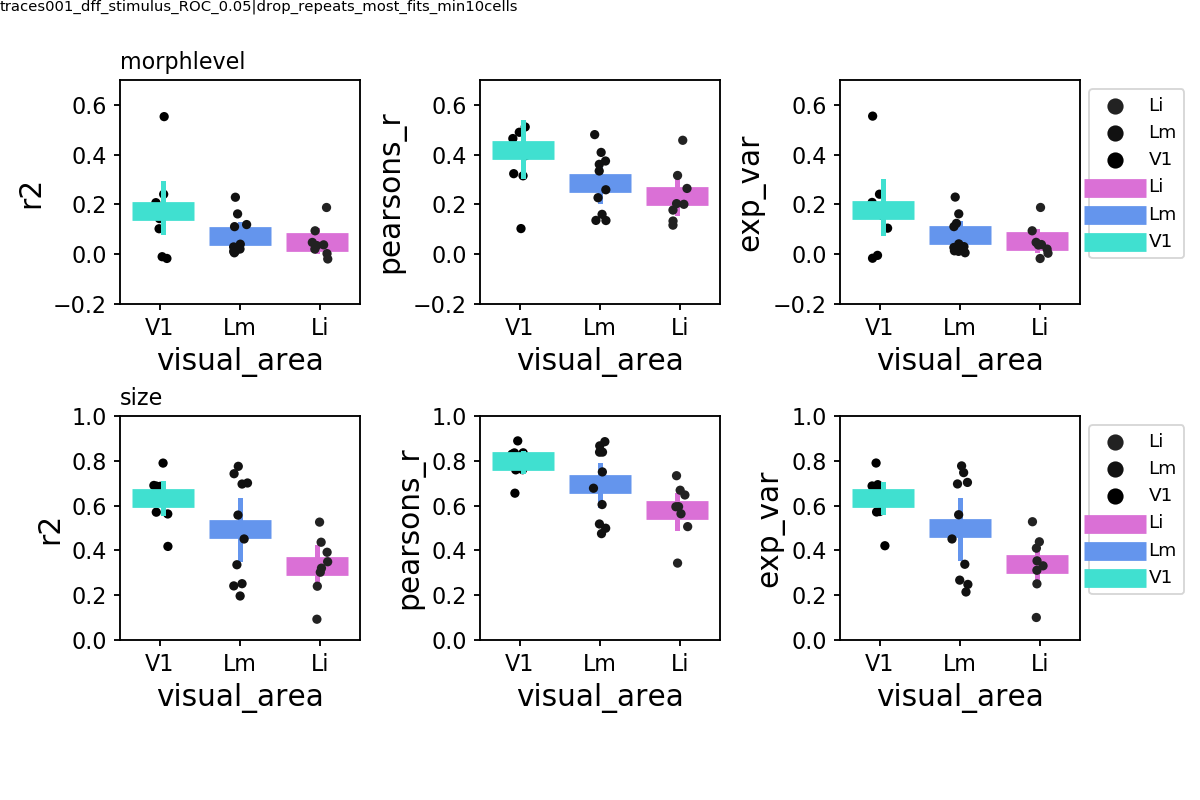

In [115]:
fig, axn = pl.subplots(2, 3, figsize=(9,6))

for ai, (regr, regdf) in enumerate(dropdf.groupby(['regressor'])):
    
    for ci, curr_metric in enumerate(['r2', 'pearsons_r', 'exp_var']):
        ax = axn[ai, ci]
        sns.stripplot(x='visual_area', y=curr_metric, data=regdf, ax=ax,
                 hue='visual_area', color='k', order=visual_areas)
        sns.pointplot(x='visual_area', y=curr_metric, data=regdf, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas, dodge=True, scale=5, markers='_')
        if ci==0:
            ax.set_title(regr, loc='left')
        if ci==2:
            ax.legend(bbox_to_anchor=(1., 1), loc='upper left')
        else:
            ax.legend_.remove()
            
        if ai==0:
            ax.set_ylim([-0.2, 0.7])
        else:
            ax.set_ylim([0, 1])
pl.subplots_adjust(wspace=0.5, left=0.1, right=0.9, bottom=0.2, top=0.9, hspace=0.5)

putils.label_figure(fig, '%s|%s' % (data_id, dset_str))

figname = 'fitmetrics_%s' % dset_str

pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))




<IPython.core.display.Javascript object>


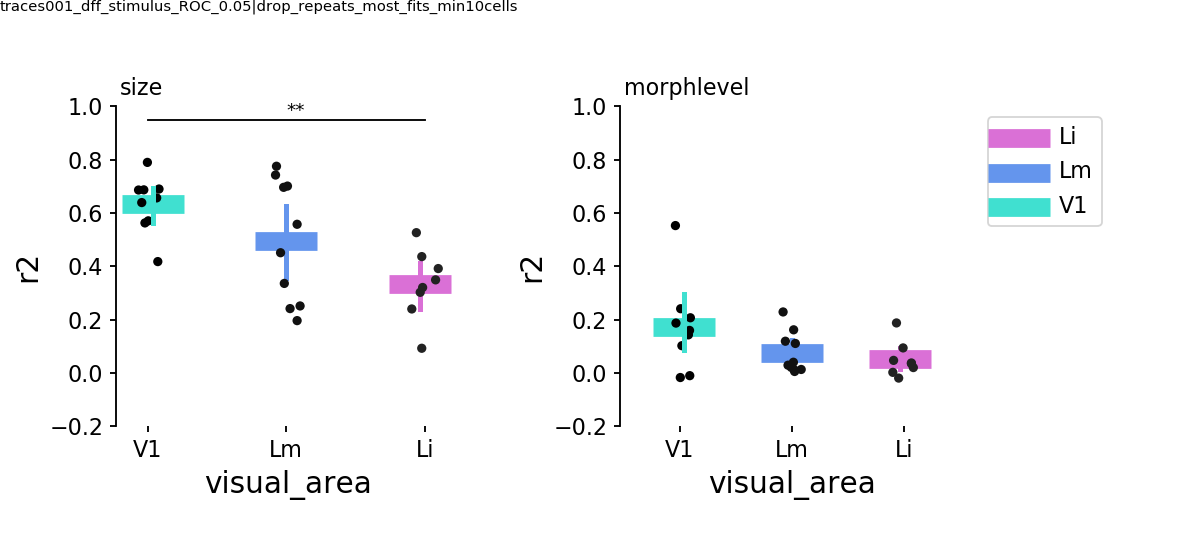

********* [r2] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.196 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.002 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.126 (fdr_bh), reject H0=False
****************************
********* [r2] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.177 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.138 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.313 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-ROC-thr-0.05/linear-regression/drop_repeats', 'r2_multicompfdr_bh__drop_repeats_most_fits_min10cells')


In [116]:
curr_metric = 'r2'

multi_comp_test='fdr_bh'
fig, axn = pl.subplots(1, 2, figsize=(9, 4))


regr_label='size'
currdf = dropdf[dropdf.regressor==regr_label].copy()
ax=axn[0]
sns.pointplot(x='visual_area', y=curr_metric, data=currdf, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas, dodge=True, scale=5, markers='_')

sns.stripplot(x='visual_area', y=curr_metric, data=currdf, ax=ax,
                 hue='visual_area', color='k', order=visual_areas)
ax.legend_.remove() #aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1.,1))

statresults, ax = aggr.plot_mannwhitney(currdf, metric=curr_metric, multi_comp_test=multi_comp_test,
                        ax=ax, y_loc=0.85, offset=0.1)
ax.set_ylim([-0.2, 1])
ax.set_title(regr_label, loc='left')

regr_label='morphlevel'
currdf = dropdf[dropdf.regressor==regr_label].copy()
ax=axn[1]
sns.pointplot(x='visual_area', y=curr_metric, data=currdf, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas, dodge=True, scale=5, markers='_')
sns.stripplot(x='visual_area', y=curr_metric, data=currdf, ax=ax,
                 hue='visual_area', color='k', order=visual_areas)
aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1.,1))
statresults, ax = aggr.plot_mannwhitney(currdf, metric=curr_metric, multi_comp_test=multi_comp_test,
                        ax=ax, y_loc=0.85, offset=0.02)
ax.set_ylim([-0.2, 1])
ax.set_title(regr_label, loc='left')


sns.despine(bottom=True, offset=2)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8, wspace=0.5)

putils.label_figure(fig, '%s|%s' % (data_id, dset_str))

figname = '%s_multicomp%s__%s' % (curr_metric, multi_comp_test, dset_str)

pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


print(curr_dst_dir, figname)

In [281]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [282]:
pp.pprint(dropdf.groupby(['visual_area', 'regressor']).mean())
pp.pprint(dropdf.groupby(['visual_area', 'regressor']).sem())


                         exp_var          mse    pearsons_p  pearsons_r  \
visual_area regressor                                                     
Li          morphlevel  0.050504  1158.217720  6.224593e-02    0.234077   
            size        0.428881   112.285751  1.099591e-11    0.652760   
Lm          morphlevel  0.069511  1137.321930  1.794801e-02    0.285418   
            size        0.533024    91.246326  1.207684e-09    0.720241   
V1          morphlevel  0.128245  1051.837920  1.317462e-02    0.363753   
            size        0.658528    68.877122  1.422132e-15    0.809761   

                              r2     n_cells     n_trials  pearsons_r_weights  \
visual_area regressor                                                           
Li          morphlevel  0.045641   52.666667  1349.833333           -0.045463   
            size        0.425416   52.666667  1349.833333           -0.045463   
Lm          morphlevel  0.064435   73.900000  1340.100000           -0.0599

<IPython.core.display.Javascript object>


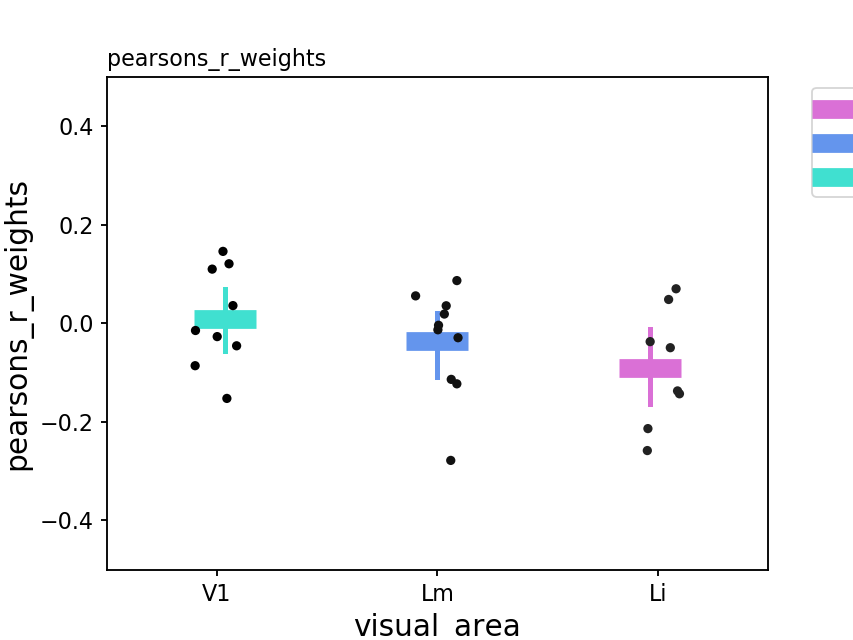

********* [pearsons_r_weights] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.270 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.169 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.200 (fdr_bh), reject H0=False
****************************


Text(0,1,u'pearsons_r_weights')

In [117]:
fig, ax = pl.subplots()
curr_metric = 'pearsons_r_weights'
currdf = xdf[['visual_area', 'datakey', 'pearsons_r_weights', 'pearsons_p_weights']].drop_duplicates().copy()

sns.pointplot(x='visual_area', y=curr_metric, data=currdf, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas, dodge=True, scale=5, markers='_')

sns.stripplot(x='visual_area', y=curr_metric, data=currdf, ax=ax,
                 hue='visual_area', color='k', order=visual_areas)

aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1.,1))
statresults, ax = aggr.plot_mannwhitney(currdf, metric=curr_metric, multi_comp_test=multi_comp_test,
                        ax=ax, y_loc=0.85, offset=0.02)
ax.set_ylim([-0.5, 0.5])
ax.set_title(curr_metric, loc='left')

In [118]:
print("~~~~~~~~ mean ~~~~~~~~~~~~~~~~~~~~~")
print(currdf.groupby(['visual_area']).mean())
print("~~~~~~~~ sem ~~~~~~~~~~~~~~~~~~~~~")
print(currdf.groupby(['visual_area']).sem())


~~~~~~~~ mean ~~~~~~~~~~~~~~~~~~~~~
             pearsons_r_weights  pearsons_p_weights
visual_area                                        
Li                    -0.090263            0.488767
Lm                    -0.036666            0.634273
V1                     0.009446            0.460159
~~~~~~~~ sem ~~~~~~~~~~~~~~~~~~~~~
             datakey  pearsons_p_weights  pearsons_r_weights
visual_area                                                 
Li               NaN            0.095495            0.041795
Lm               NaN            0.089630            0.034224
V1               NaN            0.115552            0.033766


In [289]:
regr_var1, regr_var2

('size', 'morphlevel')

In [339]:
unique_dsets = [(v, k) for v, k in dropdf[['visual_area', 'datakey']].drop_duplicates().values] #final_dsets

In [340]:
print(regr_var2)
metrics = ['r2', 'exp_var', 'mse', 'pearsons_r', 'pearsons_p']

iterdf=dict((v, []) for v in visual_areas)


for (visual_area, datakey), g in NEURALDATA.groupby(['visual_area', 'datakey']):
    if (visual_area, datakey) not in unique_dsets:
        continue
        
    print(visual_area)
    rdf = aggr.stacked_neuraldf_to_unstacked(g)
    sdf = SDF[datakey].copy()
    
    #tested_configs = sdf[sdf['morphlevel']!=-1].index.tolist()
    tested_configs = sdf[sdf['morphlevel'].isin(curr_morph_levels)].index.tolist()
    
    rois_ = [r for r in rdf.columns if putils.isnumber(r)]
    df = rdf[rdf.config.isin(tested_configs)].copy()
    config_on_trial = df['config'].values
    ddata = aggr.zscore_neuraldf(df)
    
    X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(ddata[rois_]))
    
    i_=[]
    for iternum in np.arange(0, 100):
        randi = random.randint(1, 1000)
    #     targets1 = [sdf[regr_var1][cfg] for cfg in config_on_trial]
    #     res1 = get_regr_stats(X, targets1, model=model, return_dict=True)
        targets2 = [sdf[regr_var2][cfg] for cfg in config_on_trial]
        res2 = get_regr_stats(X, targets2, model=model, return_dict=True, randi=randi)
        td = pd.DataFrame(data=np.squeeze(res2['coef_']), columns=[iternum])
        i_.append(td)

    tdf = pd.concat(i_, axis=1).T
    tdf['visual_area'] = visual_area
    tdf['datakey'] = datakey

    iterdf[visual_area].append(tdf)


morphlevel
Li
Li
Li
Li
Li
Li
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
Lm
V1
V1
V1
V1
V1
V1
V1
V1
V1


In [342]:
res2['coef_']

array([ 2.12813766,  0.87914932, -2.10105293, -0.4248163 , -0.24329172,
        1.06837408,  1.12843393,  1.34998017, -0.90550718,  0.89048145,
        0.90830853,  0.15038696, -1.12792583,  0.81609893, -1.04238923,
        2.87240418, -1.40805423, -0.14476243,  1.21199692, -1.68148301,
       -1.23695234, -0.06334775,  2.56625102,  2.60380036, -2.35618544,
        1.15665071,  2.36224461, -0.60930372, -0.61051976, -1.00387252,
       -0.31296133, -1.87191154, -1.67727663,  2.1461252 , -5.67990984,
        2.07247759,  0.92947223, -1.40489103,  0.05337589,  1.61032711,
       -1.08269421,  2.85440524,  0.61026101, -0.29713966, -0.97424357,
       -2.61984194,  0.96438573,  2.31857995, -1.05507966,  0.19858167,
       -1.82812658, -1.88187677, -3.24195811,  0.26120894,  4.34032739,
        0.72548875, -0.94555706,  0.20563118,  1.26217064, -0.21768974,
       -2.87985636,  0.1320745 ,  0.08068615,  0.93356246, -1.57179885,
        0.21564646, -0.83357652, -1.87356278, -0.5742629 , -1.94

In [329]:
import random

In [334]:

i_=[]
for iternum in np.arange(0, 100):
    randi = random.randint(1, 1000)
#     targets1 = [sdf[regr_var1][cfg] for cfg in config_on_trial]
#     res1 = get_regr_stats(X, targets1, model=model, return_dict=True)
    targets2 = [sdf[regr_var2][cfg] for cfg in config_on_trial]
    res2 = get_regr_stats(X, targets2, model=model, return_dict=True, randi=randi)

    td = pd.DataFrame(data=np.squeeze(res2['coef_']), columns=[iternum])
    i_.append(td)

tdf = pd.concat(i_, axis=1).T
tdf['visual_area'] = visual_area
tdf['datakey'] = datakey

<IPython.core.display.Javascript object>


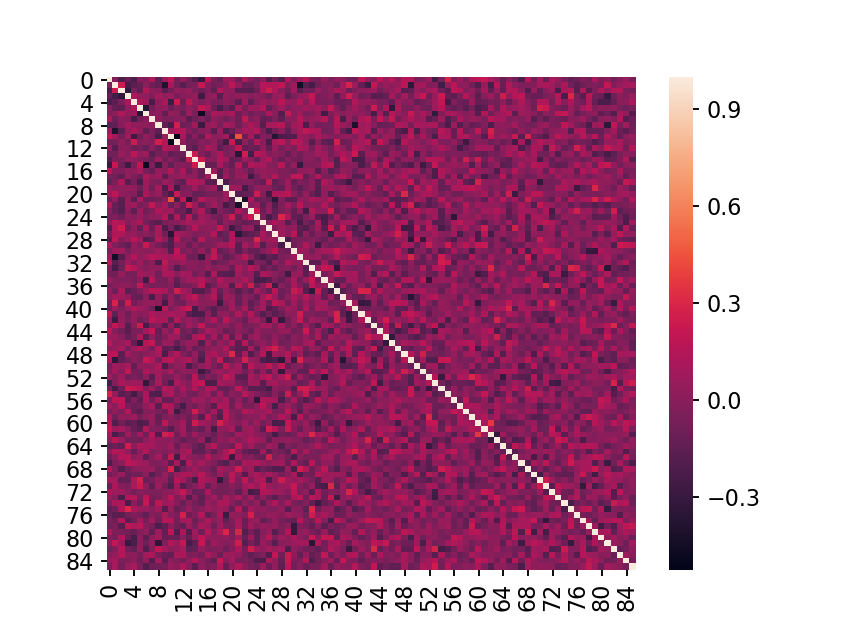

In [343]:

fig, ax = pl.subplots()
sns.heatmap(tdf.corr(),)


In [366]:
tdf.sem()

0     0.036026
1     0.043679
2     0.039562
3     0.043402
4     0.030719
5     0.031360
6     0.035383
7     0.033658
8     0.047544
9     0.036923
10    0.041514
11    0.050065
12    0.038341
13    0.044599
14    0.031607
15    0.052643
16    0.030361
17    0.034162
18    0.037167
19    0.038284
20    0.039307
21    0.045876
22    0.058781
23    0.042615
24    0.046800
25    0.028822
26    0.048934
27    0.039612
28    0.041213
29    0.036313
        ...   
56    0.025649
57    0.026638
58    0.031778
59    0.031741
60    0.039955
61    0.032304
62    0.031574
63    0.028980
64    0.034903
65    0.028446
66    0.029702
67    0.029296
68    0.036274
69    0.037756
70    0.029661
71    0.038702
72    0.033573
73    0.031454
74    0.030229
75    0.031212
76    0.034155
77    0.033887
78    0.030639
79    0.028096
80    0.029378
81    0.033742
82    0.028202
83    0.026114
84    0.029129
85    0.028938
Length: 86, dtype: float64

In [361]:
ri, roi

NameError: name 'ri' is not defined

In [363]:
roi

NameError: name 'roi' is not defined

In [32]:
do_fits

False

In [146]:
reformat_morphs = True

if do_fits:
    results = dict((visual_area, {regr_var1: [], regr_var2: []}) for visual_area in visual_areas)
    RES = dict((visual_area, dict()) for visual_area in visual_areas)

    for visual_area in visual_areas:
        dsets = sdata[(sdata['visual_area']==visual_area) & (sdata['experiment']=='blobs')]

        for (animalid, session, fov), g in dsets.groupby(['animalid', 'session', 'fov']):

            if '-'.join([animalid, session]) in excluded_sessions:
                continue

            skey = '-'.join([animalid, session, fov])
            if animalid == 'JC091' and session == '20191008':
                continue
            if animalid == 'JC113' and session == '20191018':
                continue
            exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
            # Get stimulus conditions
            sdf = exp.get_stimuli()
            sdf = reformat_morph_values(sdf)
            sizes = np.array(sorted(sdf['size'].unique()))
            morphs = np.array(sorted(sdf['morphlevel'].unique()))

            n_sizes = len(sdf['size'].unique())
            n_morphs = len(sdf['morphlevel'].unique()) 
            if n_sizes != n_sz or n_morphs != n_mp:
                incorrect_nvalues.append(skey)
                pass

            rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                                         response_type=response_type, responsive_test=responsive_test,
                                         responsive_thr=responsive_thr, n_stds=n_stds)
            #rstats = rstats['nframes_above']

            # Get metrics for each condition
            estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
            meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                               for roi in estats.rois], axis=1).T
            # Get ROI list
            if threshold_dff:
                rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
            else:
                rois_plot = meanr.index.tolist()
            print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

            dflist = [pd.DataFrame(estats.gdf.get_group(roi).sort_values(by='trial')['dff']).reset_index(drop=True)\
                      for roi in rois_plot]
            df = pd.concat(dflist, axis=1)
            df.columns = rois_plot

            sdf = reformat_morph_values(exp.data.sdf)
            excluded_configs = []
            if exclude_controls:
                excluded_configs = sdf[sdf['morphlevel']==-1].index.tolist()
                sdf = sdf[sdf['morphlevel'] != -1]
            tested_configs = [c for c in sdf.index.tolist() if c not in excluded_configs]
            
            if reformat_morphs:
                morphnum = list(sorted(sdf['morphlevel'].unique())) #np.arange(1, len(sdf['morphlevel'].unique())+1))
                morph_ixs = [morphnum.index(m) for m in sdf['morphlevel']] #np.arange(1, len(sdf['morphlevel'].unique())+1)
                sdf['morphlevel'] = morph_ixs

            labels = exp.data.labels[exp.data.labels['config'].isin(tested_configs)]
            trial_configs = np.vstack(labels.groupby(['trial'])['config'].apply(np.array).apply(np.ravel))[:, 0]
            all_trials = sorted(exp.data.labels['trial'].unique(), key=natural_keys)
            included_trials = sorted(labels['trial'].unique(), key=natural_keys)
            trial_ixs = [i for i, trial in enumerate(all_trials) if trial in included_trials]
            print len(trial_ixs)

            df = df.iloc[trial_ixs]

            X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df))

            targets1 = [sdf[regr_var1][cfg] for cfg in trial_configs]
            res1 = get_regr_stats(X, targets1, model=model)

            targets2 = [sdf[regr_var2][cfg] for cfg in trial_configs]
            res2 = get_regr_stats(X, targets2, model=model)

            results[visual_area][regr_var1].append(res1)
            results[visual_area][regr_var2].append(res2)


            RES[visual_area][skey] = {regr_var1: res1,
                                      regr_var2: res2}
        
    with open(regression_fpath, 'wb') as f:
        pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)

    with open(by_sess_regression_fpath, 'wb') as f:
        pkl.dump(RES, f, protocol=pkl.HIGHEST_PROTOCOL)

... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
['/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_blobs_static']
... run: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: ROC
-- stats: combined_blobs_static
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
NP_subtracted offset was: 58.87
adding NP offset... (NP baseline offset: 289.30)
((249000, 300), (300,), ())
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
Plotting 45 of 45 responsive cells.


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1350
ridge
ridge
... [JC076|20190501|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
['/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/combined_blobs_static']
... run: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: ROC
-- stats: combined_blobs_static
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
NP_subtracted offset was: 90.59
adding NP offset... (NP baseline offset: 347.18)
((268500, 242), (242,), ())
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
Plotting 41 of 41 responsive cells.
1350
ridge
ridge
... [JC083|20190507|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
['/n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/combined_blobs_static']
... run: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: ROC
-- stats: combined

((268500, 267), (267,), ())
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
Plotting 87 of 87 responsive cells.
1350
ridge
ridge
... [JC078|20190509|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
['/n/coxfs01/2p-data/JC078/20190509/FOV1_zoom2p0x/combined_blobs_static']
... run: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: ROC
-- stats: combined_blobs_static
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
NP_subtracted offset was: 103.98
adding NP offset... (NP baseline offset: 374.32)
((268500, 295), (295,), ())
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
Plotting 69 of 69 responsive cells.
1350
ridge
ridge
... [JC078|20190513|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs

... loading ROI stats: ROC
-- stats: combined_blobs_static
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
NP_subtracted offset was: 12.62
adding NP offset... (NP baseline offset: 524.30)
((220725, 271), (271,), ())
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
Plotting 141 of 141 responsive cells.
1440
ridge
ridge
... [JC091|20190602|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
['/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_blobs_static']
... run: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: ROC
-- stats: combined_blobs_static
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
NP_subtracted offset was: 62.92
adding NP offset... (NP baseline offset: 372.48)
((202365, 356), (356,), ())
... adjusting 

In [147]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-ROC-thr-0.05/linear-regression'

In [148]:
print(regression_fpath)
print(by_sess_regression_fpath)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-ROC-thr-0.05/linear-regression/regression_stats_ridge_rename-morphs.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-ROC-thr-0.05/linear-regression/regression_stats_ridge_by-session_rename-morphs.pkl


## Read

In [33]:
regression_fpath = os.path.join(outdir, 'regression_stats_%s%s.pkl' % (model, reformat_str))
with open(regression_fpath, 'rb') as f:
    results = pkl.load(f)
results.keys()

['V1', 'Lm', 'Li']

In [34]:
visual_areas = ['V1', 'Lm', 'Li']
#colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
colors = ['magenta', 'orange', 'dodgerblue']
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

In [35]:
x = results[visual_area]['morphlevel'][0]

In [36]:
[np.mean([e.r2 for e in results[visual_area]['morphlevel']]) for visual_area in visual_areas]
        

[0.2169069577435822, 0.06034393930695301, 0.015208302000983748]

In [37]:
[e.r2 for e in results['Li']['size']] #if e.r2 >= -3.5]

[0.5474684382572408,
 0.645278740533325,
 0.5642349874880078,
 0.6424764306890844,
 0.5941692837692079,
 0.6454566158587662,
 0.6344778628261305,
 0.3768322381541058,
 0.5452586949712324,
 0.11526940664349372,
 0.643232656580493,
 0.23287515313233753]

In [38]:
for skey, res in RES['V1'].items():
    print skey, res['size'].r2

JC076-20190501-FOV1_zoom2p0x 0.3606503804033011
JC084-20190522-FOV1_zoom2p0x 0.7144502923973659
JC097-20190616-FOV1_zoom2p0x 0.7797379135428518
JC097-20190613-FOV1_zoom2p0x 0.5163457951636834
JC083-20190507-FOV1_zoom2p0x 0.7948652090143546
JC110-20191006-FOV1_zoom2p0x 0.5837932171237781
JC083-20190511-FOV1_zoom2p0x 0.6750435794550371
JC076-20190420-FOV1_zoom2p0x 0.5590615568242405
JC083-20190510-FOV1_zoom2p0x 0.6900375748323581
JC085-20190622-FOV1_zoom2p0x 0.660290885211736
JC097-20190617-FOV1_zoom2p0x 0.6159620934305325


In [39]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-ROC-thr-0.05/linear-regression'

<IPython.core.display.Javascript object>


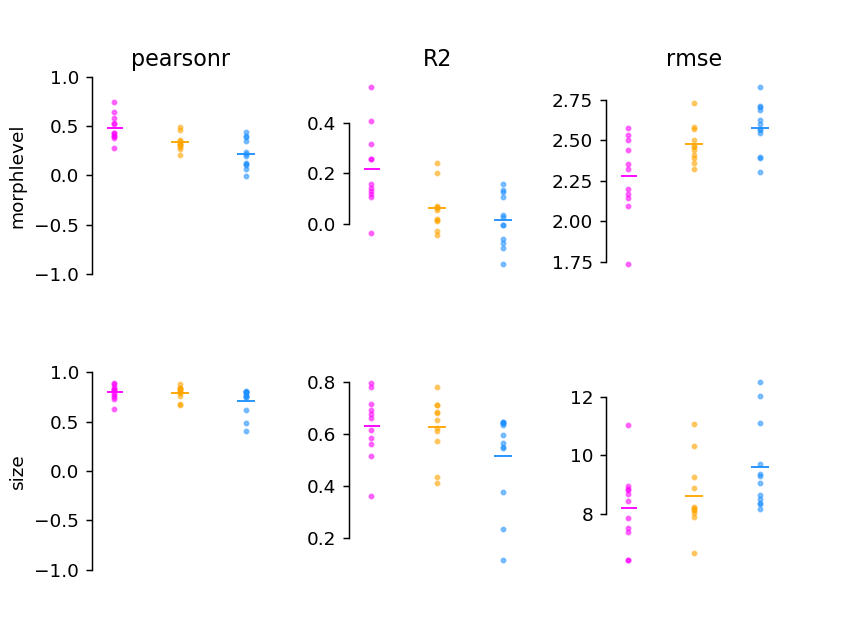

In [41]:
fig, axes = pl.subplots(2, 3, sharex=True)
marker= '.'
marker_size = 20
alpha=0.5
for vi, visual_area in enumerate(visual_areas): #results.keys():
    facecolor = area_colors[visual_area] #'none'
    values = [e.pearsons_r for e in results[visual_area]['morphlevel']]
    axes[0, 0].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[0, 0].plot(vi, np.mean(values), marker='_', markersize=10, alpha=1.,
                   c=facecolor)
    
    values = [e.pearsons_r for e in results[visual_area]['size']]
    axes[1, 0].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[1, 0].plot(vi, np.mean(values), marker='_', markersize=10, alpha=1.,
                   c=facecolor)
    axes[0, 0].set_title('pearsonr')
    axes[0, 0].set_ylabel('morphlevel')
    axes[1, 0].set_ylabel('size')
    axes[0, 0].set_ylim([-1, 1])
    axes[1, 0].set_ylim([-1, 1])

    values = [e.r2 for e in results[visual_area]['morphlevel']]
    axes[0, 1].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[0, 1].plot(vi, np.mean(values), marker='_', markersize=10, alpha=1.,
                   c=facecolor)
    values = [e.r2 for e in results[visual_area]['size']]
    axes[1, 1].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[1, 1].plot(vi, np.mean(values), marker='_', markersize=10, alpha=1.,
                   c=facecolor)
    
    axes[0, 1].set_title('R2')
    #axes[0, 1].set_ylim([0, 1]) #; axes[0, 1].set_yticks([0, 1]);
    #axes[1, 1].set_ylim([0, 1]) #; axes[1, 1].set_yticks([0, 1]);

    values = [np.sqrt(e.mse) for e in results[visual_area]['morphlevel']]
    axes[0, 2].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[0, 2].plot(vi, np.mean(values), marker='_', markersize=10, alpha=1.,
                   c=facecolor)
    
    values = [np.sqrt(e.mse) for e in results[visual_area]['size']]
    axes[1, 2].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[0, 2].set_title('rmse')
    axes[1, 2].plot(vi, np.mean(values), marker='_', markersize=10, alpha=1.,
                   c=facecolor)
    
sns.despine(bottom=True, trim=True, offset=8)
for ax in axes.flat:
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xticklabels([])
pl.subplots_adjust(wspace=0.75, hspace=0.5)
    
pl.savefig(os.path.join(outdir, '%s_regr_morph-size_stats-all.png' % model))

In [345]:
exp.data.labels.shape

(128250, 8)

In [346]:
len(exp.data.labels['trial'].unique())

950

In [347]:
len(trial_configs)

855

In [41]:
import scipy.stats as spstats

In [42]:
Rvals = {}
Pvals = {}
for visual_area in visual_areas:
    coefs = [spstats.pearsonr(mp.regr.coef_, sz.regr.coef_)\
                   for mp, sz in zip(results[visual_area]['morphlevel'], results[visual_area]['size'])]
    mean_pearsonsr = np.mean([c[0] for c in coefs])
    std_pearsonsr = spstats.sem([c[0] for c in coefs])
    Rvals[visual_area] = [c[0] for c in coefs]
    Pvals[visual_area] = [c[1] for c in coefs]
    
    print visual_area, mean_pearsonsr, std_pearsonsr

V1 -0.00138163892495 0.0323811631619
Lm -0.0175016268033 0.0294315220611
Li -0.0705662180584 0.0520186196968


<IPython.core.display.Javascript object>


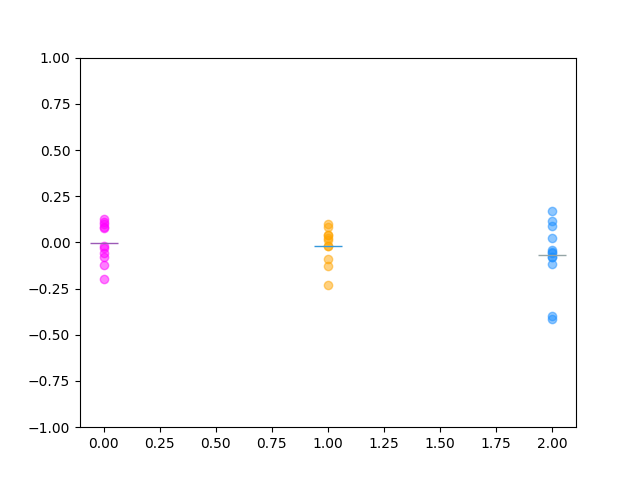

(-1, 1)

In [45]:
pl.figure()

for vi, visual_area in enumerate(visual_areas):
    vals = Rvals[visual_area]
    pl.scatter([vi for _ in range(len(vals))], vals, alpha=0.5, c=area_colors[visual_area])
    pl.plot(vi, np.mean(vals), marker='_', markersize=20)
pl.ylim([-1, 1])

#pl.savefig(os.path.join(outdir, '%s-regr_morph-size_coef-corr-pearsonsr.png' % model))#
#pl.savefig(os.path.join(outdir, '%s-regr_morph-size_coef-corr-pearsonsr.svg' % model))

In [57]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-ROC-thr-0.05/linear-regression'

<IPython.core.display.Javascript object>


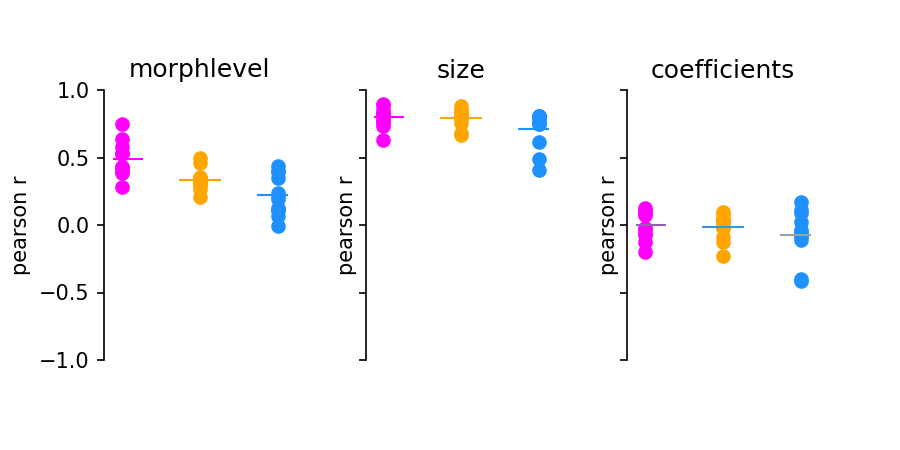

In [160]:
markersize = 20
marker = 'o'

fig, axes = pl.subplots(1,3, figsize=(6,3), dpi=150, sharey=True)
fig.patch.set_alpha(0)

for vi, visual_area in enumerate(visual_areas): #results.keys():
    facecolor = area_colors[visual_area] #'none'
    
    values = [e.pearsons_r for e in results[visual_area]['morphlevel']]
    axes[0].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area])
                       #s=markersize, alpha=alpha)
    axes[0].plot(vi, np.mean(values), marker='_', markersize=markersize, alpha=1.,
                   c=facecolor)
    axes[0].set_title('morphlevel')
    
    values = [e.pearsons_r for e in results[visual_area]['size']]
    axes[1].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area]) #, 
#                        s=markersize, alpha=alpha)
    axes[1].plot(vi, np.mean(values), marker='_', markersize=markersize, alpha=1.,
                   c=facecolor)
    axes[1].set_title('size')

    vals = Rvals[visual_area]
    axes[2].scatter([vi for _ in range(len(vals))], vals, alpha=1., c=area_colors[visual_area])
    axes[2].plot(vi, np.mean(vals), marker='_', markersize=markersize)
    axes[2].set_title('coefficients')

for ax in axes.flat:
    ax.patch.set_alpha(0)
    #axes[0, 0].set_title('pearsonr')
    ax.set_ylabel('pearson r')
    #axes[1].set_ylabel('pearson r')
    ax.set_ylim([-1, 1])
    
    ax.set_xticks([])

pl.subplots_adjust(bottom=0.2, top=0.8, wspace=0.5)
sns.despine(offset=4, trim=True, bottom=True)
figname = '%s-regr_pearsonr_morphlevel_size_coefficients_rename' % model
pl.savefig(os.path.join(outdir, '%s.svg' % figname))



<IPython.core.display.Javascript object>


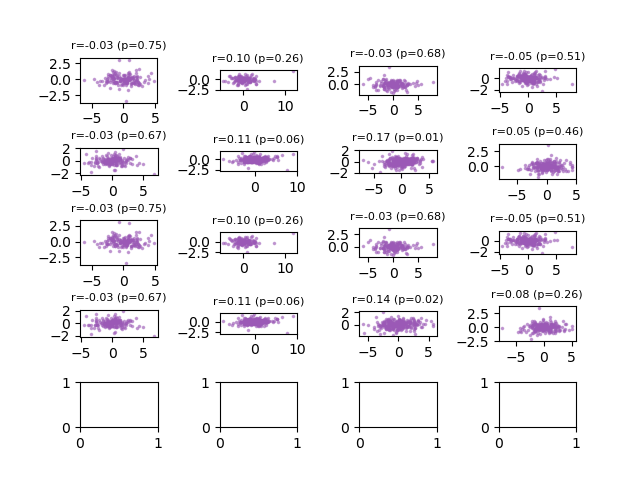

In [323]:
visual_area = 'V1'

fig, axes = pl.subplots(5, 4)

nsessions = len(results[visual_area]['morphlevel'])
for ax, si in zip(axes.flat, range(nsessions)):

    coefs_morph = results[visual_area]['morphlevel'][si].regr.coef_
    coefs_size = results[visual_area]['size'][si].regr.coef_
    ax.scatter(coefs_morph, coefs_size, marker='.', s=10, alpha=0.5)
    ax.set_aspect('equal')

    r, p = spstats.pearsonr(coefs_morph, coefs_size)
    ax.set_title('r=%.2f (p=%.2f)' % (r, p), fontsize=8)
pl.subplots_adjust(wspace=0.8, hspace=0.8)

<IPython.core.display.Javascript object>


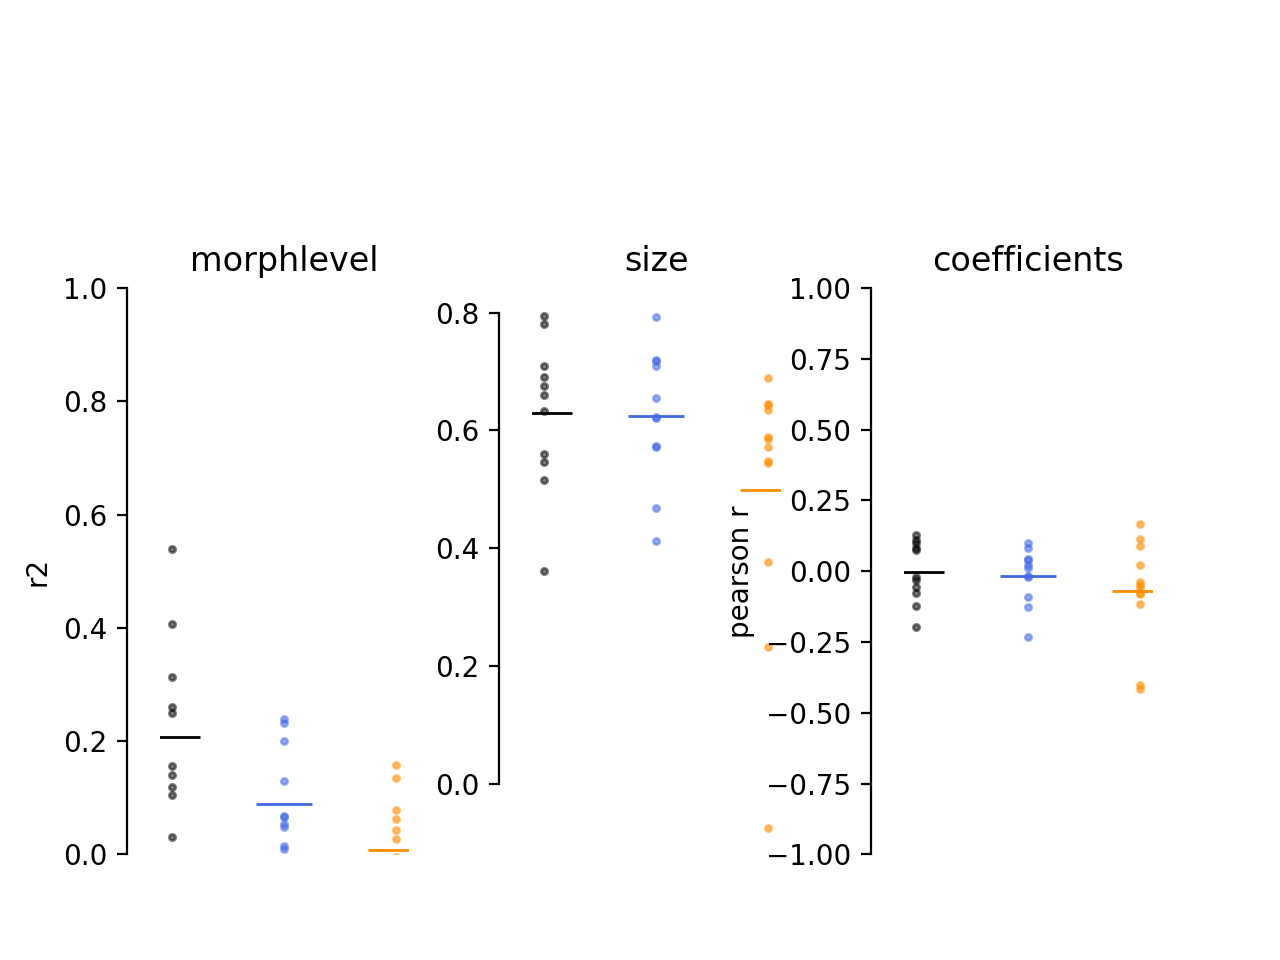

In [93]:
fig, axes = pl.subplots(1, 3, sharex=False, sharey=False)
marker= '.'
marker_size = 20
alpha=0.5
curr_metric = 'r2'

for vi, visual_area in enumerate(visual_areas): #results.keys():
    facecolor = area_colors[visual_area] #'none'
    if curr_metric == 'RMSE':
        values = [np.sqrt(e.mse) for e in results[visual_area]['morphlevel']]
    else:
        values = [e.r2 for e in results[visual_area]['morphlevel']]
        
    axes[0].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[0].plot(vi, np.mean(values), marker='_', markersize=marker_size, alpha=1., c=facecolor)

    if curr_metric == 'RMSE':
        values = [np.sqrt(e.mse) for e in results[visual_area]['size']]
    else:
        values = [e.r2 for e in results[visual_area]['size']]
        
    axes[1].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[1].plot(vi, np.mean(values), marker='_', markersize=marker_size, alpha=1., c=facecolor)

    axes[0].set_title('morphlevel')
    axes[1].set_title('size')
    axes[0].set_ylabel(curr_metric)
    
    # COEFS.
    rr = results[visual_area]
    pearsonvals = [spstats.pearsonr(rr['morphlevel'][i].regr.coef_, rr['size'][i].regr.coef_) for i in np.arange(0, len(rr['size']))]
    values = [c[0] for c in pearsonvals]

    axes[2].scatter([vi for _ in range(len(values))], values,
                       marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                       s=marker_size, alpha=alpha)
    axes[2].plot(vi, np.mean(values), marker='_', markersize=marker_size, alpha=1., c=facecolor)

    axes[2].set_title('coefficients')
    axes[2].set_ylabel('pearson r')

if curr_metric not in ['RMSE', 'MSE']:
    axes[0].set_ylim([0, 1])
    axes[0].set_ylim([0, 1])
else:
    ymax = max([axes[0].get_ylim()[-1], axes[1].get_ylim()[-1]])
    axes[0].set_ylim([0, ymax])
    axes[1].set_ylim([0, ymax])

axes[2].set_ylim([-1, 1])


sns.despine(bottom=True, trim=True, offset=12)
for ax in axes.flat:
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xticklabels([])
pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.7)

pl.savefig(os.path.join(outdir, '%s-regr_morph-size_R2_bmo.svg' % model))
#pl.savefig(os.path.join(outdir, '%s-regr_morph-size_R2.svg' % model))

In [368]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-nstds-thr-10.00/linear-regression'

<IPython.core.display.Javascript object>


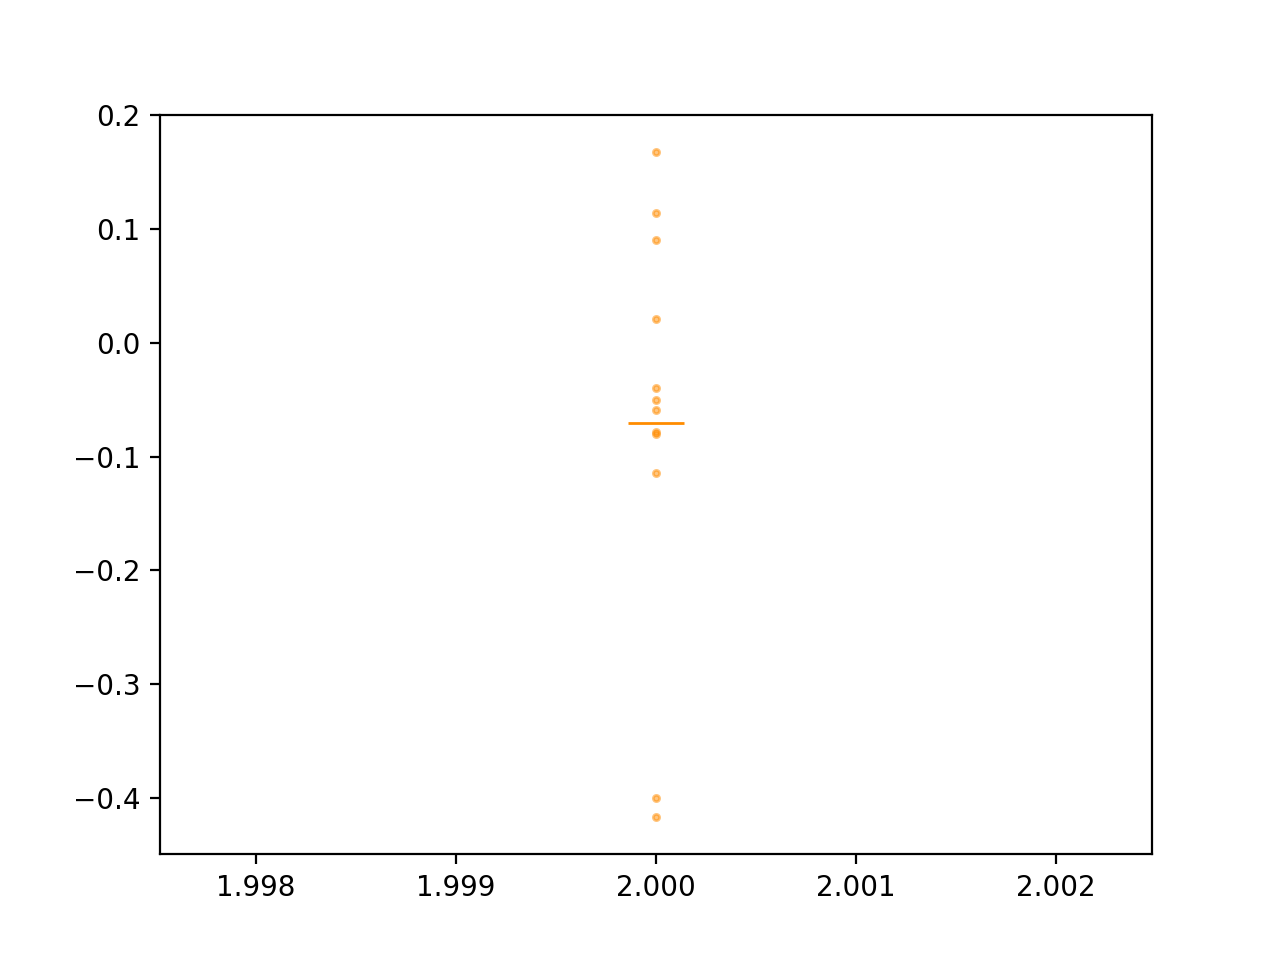

NameError: name 'a' is not defined

In [89]:
fig, ax = pl.subplots()

rr = results[visual_area]
pearsonvals = [spstats.pearsonr(rr['morphlevel'][i].regr.coef_, rr['size'][i].regr.coef_) for i in np.arange(0, len(rr['size']))]
values = [c[0] for c in pearsonvals]
        
ax.scatter([vi for _ in range(len(values))], values,
                   marker=marker, facecolor=facecolor, edgecolor=area_colors[visual_area], 
                   s=marker_size, alpha=alpha)
ax.plot(vi, np.mean(values), marker='_', markersize=marker_size, alpha=1., c=facecolor)

a.set_title('morphlevel')
ax.set_title('size')
ax.set_ylabel(curr_metric)

In [85]:
import scipy.stats as spstats

In [88]:
rr = results[visual_area]
pearsonvals = [spstats.pearsonr(rr['morphlevel'][i].regr.coef_, rr['size'][i].regr.coef_) for i in np.arange(0, len(rr['size']))]
values = [c[0] for c in pearsonvals]


[0.090243796529195591,
 -0.058962320930327675,
 -0.078484657421428142,
 0.16725271284663801,
 0.021212937032514728,
 -0.0504936278885601,
 0.11401913916650402,
 -0.079983853853916029,
 -0.039698971480186127,
 -0.40029702288362418,
 -0.11468368915777871,
 -0.41691905865957474]

In [82]:
results[visual_are]

1499

In [392]:
avg_tcorrs = {}
for visual_area in visual_areas: #.items():
    values = [e.r2 for e in results[visual_area]['morphlevel']]
    avg_tcorrs[visual_area] = values

In [393]:
c1 = avg_tcorrs['V1']
c2 = avg_tcorrs['Lm']
c3 = avg_tcorrs['Li']

In [394]:
# Shapiro-Wilk normality test 
spstats.shapiro(c1), spstats.shapiro(c2), spstats.shapiro(c3) 

((0.9045979380607605, 0.31758472323417664),
 (0.9341418147087097, 0.58664870262146),
 (0.9559277296066284, 0.7831317782402039))

In [395]:
# Levene variance test  
spstats.levene(c1, c2, c3)

LeveneResult(statistic=0.7099464375664447, pvalue=0.5042563137954063)

In [396]:
F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

F statistic = 3.732 and probability p = 0.043


In [397]:
scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
print(scores.shape)
print(groups.shape)

(22,)
(22,)


In [399]:
import statsmodels.stats.multicomp as ml

# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Li     Lm    0.0508  -0.0923 0.1939 False 
  Li     V1    0.1459   0.0073 0.2845  True 
  Lm     V1    0.0951  -0.0435 0.2337 False 
--------------------------------------------
